In [1]:
import os, sys
root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)

In [2]:
from e_nose import file_reader 
from e_nose import data_processing as dp
from e_nose import data_visualization
from e_nose.measurements import Measurement

%reload_ext autoreload
%autoreload 2

# Process data

read in data from a specific file

or all files from a from a directory

In [3]:
data_tuple = file_reader.read_all_files_in_folder('../data/newgen-test')
#data_tuple = dp.remove_broken_channels_multi_files(data_tuple)
functionalisations, working_channels, all_data = data_tuple

Reading file ../data/newgen-test/data_apple_juice_coffee_powder_red_Wine_wodka_orange_juice_raisin_8_loops_for_5.0_min_referenceTime_30.0_min_2020-2-18_7_14.csv
using sensor 5 specification
Read 1 files


../data/newgen-test/data_apple_juice_coffee_powder_red_Wine_wodka_orange_juice_raisin_8_loops_for_5.0_min_referenceTime_30.0_min_2020-2-18_7_14.csv


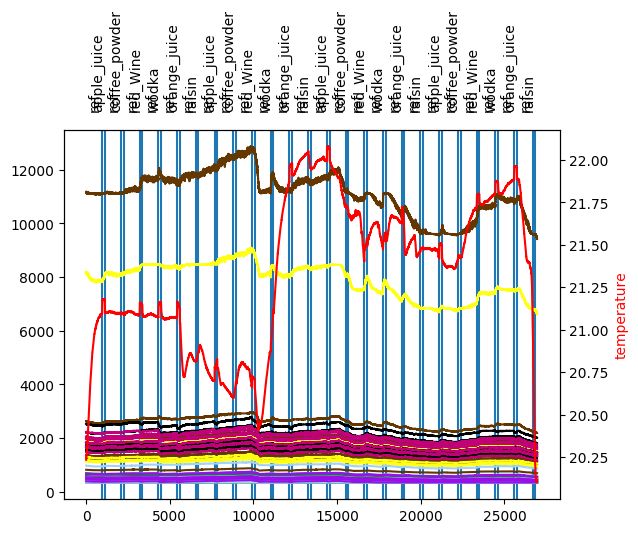

In [4]:
data_visualization.draw_all_channel_data_as_line(all_data, functionalisations, secondary='temperature')

../data/newgen-test/data_apple_juice_coffee_powder_red_Wine_wodka_orange_juice_raisin_8_loops_for_5.0_min_referenceTime_30.0_min_2020-2-18_7_14.csv


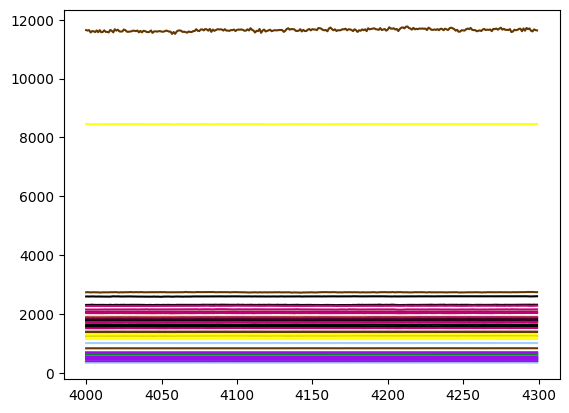

In [5]:
data_visualization.draw_all_channel_data_as_line(all_data, functionalisations, 4000 , 4300)

../data/newgen-test/data_apple_juice_coffee_powder_red_Wine_wodka_orange_juice_raisin_8_loops_for_5.0_min_referenceTime_30.0_min_2020-2-18_7_14.csv


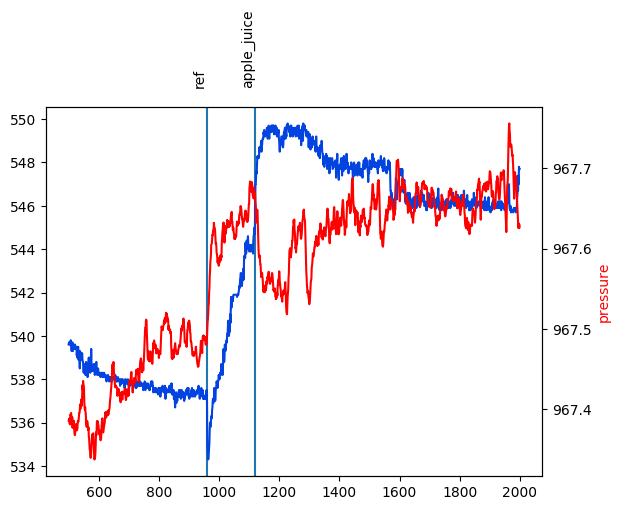

In [6]:
import matplotlib.pyplot as plt
import numpy as np
data_visualization.draw_selected_channel_data_as_line(all_data, functionalisations,
                                                      range(0,1), 500, 2000, 'pressure')

## Data normalization tests

In [139]:
import numpy as np
data = next(iter(all_data.values()))

In [140]:
num_channels = len(functionalisations)
orig_data_matrix = np.zeros((len(data), num_channels))

for i, time in enumerate(data):
    channel_data = data[time]['channels']
    orig_data_matrix[i, :] = channel_data

data_matrix = orig_data_matrix

In [147]:
# log scale
data_matrix = np.log(orig_data_matrix)

# high-pass filter
l1_filter = data_matrix[0]
l1_factor = 0#1e-3
for i in range(len(data_matrix)):
    l1_filter = (l1_filter + data_matrix[i] * l1_factor) / (1.0+l1_factor)
    data_matrix[i] -= l1_filter

# remove baseline functionalisation 0
func_0 = np.mean(data_matrix[:], axis=1, keepdims=True)
data_matrix = data_matrix - func_0

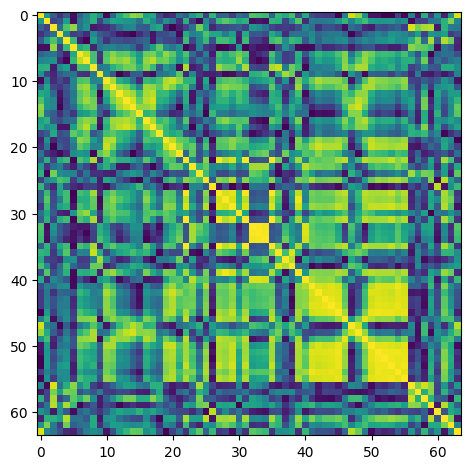

In [207]:
corr = np.corrcoef(data_matrix[:], rowvar=False)

fig, ax = plt.subplots()
im = ax.imshow(np.abs(corr))
fig.tight_layout()
plt.show()


[ 1  5  7  8 12 13 16 17 18 36 60 40]
(26952, 12)


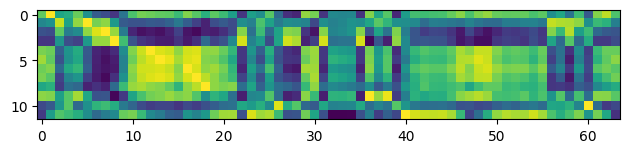

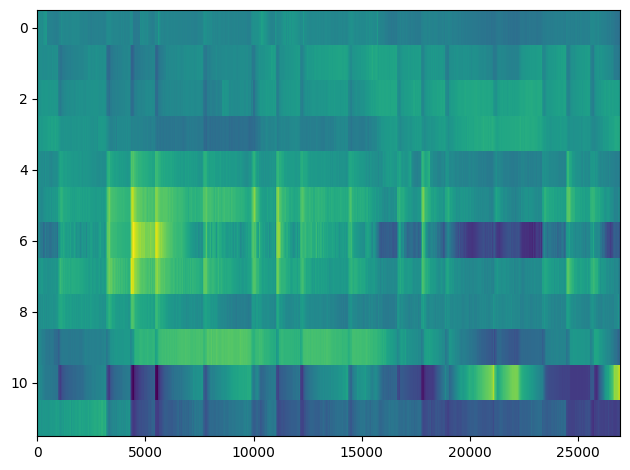

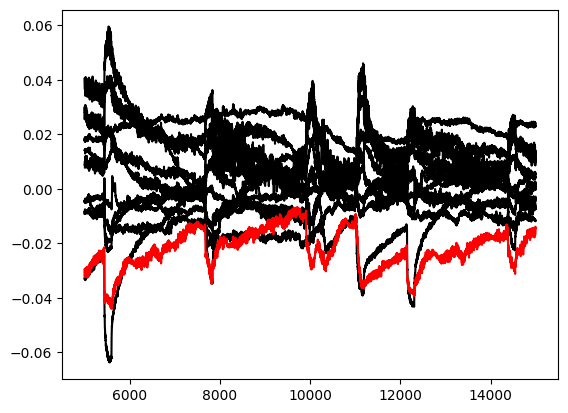

In [222]:
# Channels that are very similar / dissimilar to:
c = 40
#cgroup = np.append(np.where(corr[c] > 0.8), c)
cgroup = np.append(np.where(np.abs(corr)[c] < 0.2), c)
print(cgroup)
print(np.squeeze(data_matrix[:,cgroup]).shape)

fig, ax = plt.subplots()
im = ax.imshow(np.squeeze(corr[cgroup]))
fig.tight_layout()
plt.show()

fig, ax = plt.subplots()
im = ax.imshow(np.squeeze(data_matrix[:,cgroup]).T, aspect='auto')
fig.tight_layout()
plt.show()

num_from = 5000
num_to = 15000
fig, ax = plt.subplots()
for cg in cgroup:
    ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, i])),
        data_matrix[num_from:num_to, cg], color=('r' if cg==c else 'k'))
plt.show()

In [161]:
# Cluster channels that behave similarly

from scipy.cluster.vq import kmeans2
#centroid, label = kmeans2(data_matrix.T, 10, minit='points', iter=100)
centroid, label = kmeans2(np.abs(corr), 5, minit='points', iter=100)
label

array([2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 1, 3, 3, 3, 3, 2, 3, 3, 2, 1, 1, 1,
       0, 4, 2, 0, 2, 0, 0, 0, 3, 0, 4, 4, 4, 0, 3, 2, 2, 0, 4, 0, 1, 0,
       0, 0, 3, 2, 3, 3, 0, 0, 0, 0, 0, 0, 2, 2, 2, 4, 2, 0, 3, 2],
      dtype=int32)

[0 0 0 0 0]
2
(array([], dtype=int64),)


<ipython-input-162-6c76c72ccdab>:8: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  im = ax.imshow(pcorr)
<ipython-input-162-6c76c72ccdab>:8: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  im = ax.imshow(pcorr)


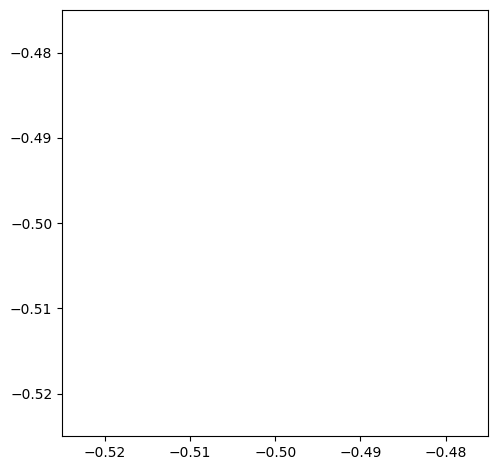

In [162]:
brokens = [22,27,31,35,39]
print(label[brokens])
print(label[47])
print(np.where(label == 6))
pcorr = np.corrcoef(data_matrix[:, label==6], rowvar=False)

fig, ax = plt.subplots()
im = ax.imshow(pcorr)
fig.tight_layout()
plt.show()

In [ ]:
new_funcs = np.array(
    [1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
     3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4,
     5, 5, 5, 5, 5, 5, 5, 5, 0, 0, 0, 0, 0, 0, 0, 0,
     6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7]
)

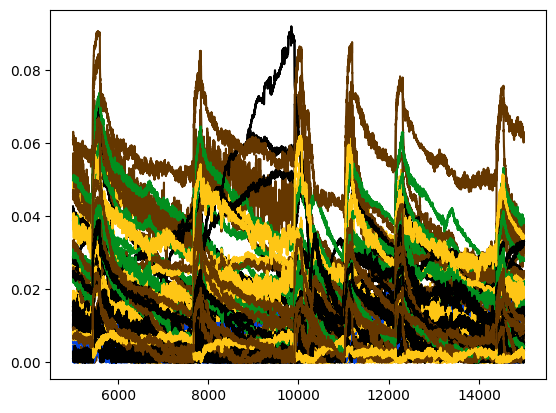

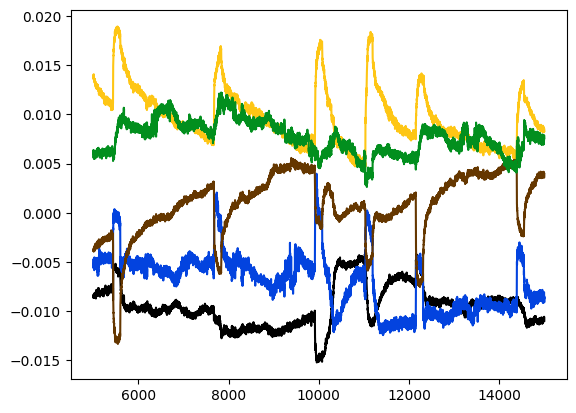

In [163]:
num_from = 5000
num_to = 15000
channels = np.array(range(num_channels))#[label==4]#range(0, num_channels, 1) #range(num_channels)

colors = ['xkcd:black', 'xkcd:blue', 'xkcd:brown', 'xkcd:golden yellow', 'xkcd:emerald green',
              'xkcd:baby blue', 'xkcd:magenta', 'xkcd:violet', 'xkcd:lightgreen', 'xkcd:dark rose',
          'xkcd:brownish green']
fig, ax = plt.subplots()
for i in channels:
    ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, i])), np.abs(data_matrix[num_from:num_to, i]),
            color=colors[label[i]])
#for f in range(max(functionalisations)+1):
#    ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, 0])),
#            np.mean(data_matrix[num_from:num_to, functionalisations == f], axis=1),
#            color=colors[f])
plt.show()


fig, ax = plt.subplots()
for f in range(max(label)+1):
    ax.plot(range(num_from, num_from+len(data_matrix[num_from:num_to, 0])),
            np.mean(data_matrix[num_from:num_to, label == f], axis=1),
            color=colors[f])
plt.show()

In [10]:
measurements_per_file = {}
for file in data:
    measurements_per_file[file] = dp.get_labeled_measurements(data[file])

In [13]:
measurements = []
for file in measurements_per_file:
    print("file: ",file)
    adding = dp.standardize_measurements_2(measurements_per_file[file])
    if adding is not None:
        measurements.extend(adding)

print(len(measurements))

0
